In [553]:
# !pip install markdownify

In [1]:
import sys
import requests
import pathlib
from collections import Counter
from datetime import datetime

from bs4 import BeautifulSoup
import pandas as pd
import xmltodict
from IPython.display import Image
from markdownify import markdownify as md
from langchain.docstore.document import Document

# Add src to path to enable relative import
sys.path.append(str(pathlib.Path("src/").absolute()))
from src.webcrawler import WebCrawler, get_sitemap_urls

# Show multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Helpers and Constants

In [2]:
def extract_xml_urls(url):
    sitemap = requests.get(f"{url}/sitemap.xml")
    map_dict = xmltodict.parse(sitemap.text)
    return map_dict["urlset"]["url"]

import tiktoken

OPENAI_MODEL_NAMES = {
    "gpt-3.5-turbo-0613",
    "gpt-3.5-turbo-16k-0613",
    "gpt-4-0314",
    "gpt-4-32k-0314",
    "gpt-4-0613",
    "gpt-4-32k-0613",
}

def num_tokens_from_text(text, model: str):
    """Return the number of tokens used by text."""
    if model not in OPENAI_MODEL_NAMES:
        raise ValueError(f"Model name must be one of {OPENAI_MODEL_NAMES}")

    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

In [3]:
TELSTRA_URL = "https://www.telstra.com.au/"
ANALYSIS_SAVE_DIR = pathlib.Path("analysis/")
ANALYSIS_SAVE_DIR.mkdir(exist_ok=True)

# Analyse Sitemap and URLs

In [4]:
telstra_url_dicts = extract_xml_urls(TELSTRA_URL)
site_df = pd.DataFrame(telstra_url_dicts)
# Show examples
site_df.head()

,loc,lastmod,changefreq,priority
0,https://www.telstra.com.au/5g,2024-01-16,daily,1.0
1,https://www.telstra.com.au/,2024-01-16,daily,1.0
2,https://www.telstra.com.au/5g/phones-devices,2024-01-16,daily,1.0
3,https://www.telstra.com.au/aboutus,2024-01-16,daily,1.0
4,https://www.telstra.com.au/?direct,2024-01-16,daily,1.0


In [5]:
pages_of_interest = [
    "https://www.telstra.com.au/consumer-advice/your-information", # Collapsible dropdown content
    "https://www.telstra.com.au/help/critical-information-summaries/business/telstra-business-services/telstra-business-website-services/Telstra-Business-Website-Services-Premium-Website-Plan", # Table content that gets mangled by Langchain
    "https://www.telstra.com.au/support/internet-and-home-phone/connecting-to-wifi", # Example support page
    "https://www.telstra.com.au/small-business/online-support/accounts-payments/late-payment-fee", # Business support page, and also has dialog content (Search for 'Press Escape to close this dialog')
    "https://www.telstra.com.au/accessories/smart-watches/apple/watch-series-9-gps-plus-cellular-41mm-silver-aluminium-case-with-storm-blue-sport-band-s-m", # Product page
    "https://www.telstra.com.au/support/email/outlook", # Support page with buttons to toggle content, and list of steps that should not be split
]

In [6]:
# Analyse URLs
print("Number of pages:", len(site_df))

print("Most popular sub-pages:")
site_df["sub_page_split"] = site_df["loc"].apply(lambda x: x.split("://")[1].split("/")[:2])
site_df["sub_page_split"].apply(lambda sub_list: "/".join(sub_page for sub_page in sub_list[:2])).value_counts().head(20).reset_index().rename(columns={"sub_page_split": "Site Subsection", "count": "Page Count"}).set_index("Site Subsection")

Number of pages: 2688
Most popular sub-pages:


,Page Count
Site Subsection,
www.telstra.com.au/business-enterprise,630
www.telstra.com.au/accessories,494
www.telstra.com.au/small-business,319
www.telstra.com.au/support,185
www.telstra.com.au/aboutus,173
www.telstra.com.au/mobile-phones,123
www.telstra.com.au/help,109
www.telstra.com.au/smarter-business,100
www.telstra.com.au/exchange,91


In [7]:
# Analyse change frequency/last modified
print("Change frequency values:")
site_df["changefreq"].value_counts().reset_index().set_index("changefreq")

today = datetime.today()
print("\nCurrent date:", today.strftime("%Y-%m-%d"))
print("Last modified values:")

site_df["lastmod"].value_counts().reset_index().set_index("lastmod")

# Convert str date time datetime object
time_since_lastmod_counter = dict(Counter([(today - datetime.strptime(url["lastmod"], "%Y-%m-%d")).days for url in telstra_url_dicts]))
print("Days-since-modified values")
site_df["lastmod"].apply(lambda d: f'{(today - datetime.strptime(d, "%Y-%m-%d")).days} days').value_counts().reset_index().set_index("lastmod")

Change frequency values:


,count
changefreq,
daily,2688



Current date: 2024-01-25
Last modified values:


,count
lastmod,
2024-01-16,2688


Days-since-modified values


,count
lastmod,
9 days,2688


# Inspect page sample
Verify that the current scraping and processing methods are correctly extracting the website content.

In [8]:
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.firefox.options import Options

# class SeleniumCrawler(object):
#     """
#     Class to handle the crawling of webpages
#     """

#     def __init__(self) -> None:
#         options = Options()
#         options.headless = True
#         self._driver = webdriver.Firefox(options=options)

#     def scrape_page_content_to_html(self, url: str) -> str:
#         self._driver.get(url)
#         elements = self._driver.find_elements(By.XPATH, "//*[@id='main']")
#         soup = BeautifulSoup(elements, "html.parser")
#         main_content_html = "".join([str(i) for i in soup.find("main", {"id": "main"})])
#         return main_content_html    

In [513]:
from selenium.webdriver.firefox.options import Options as FirefoxOptions
from selenium import webdriver

options = FirefoxOptions()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)

def save_page_screenshot_and_return_html(driver, url, save_path) -> None:
    driver.get(url)
    driver.save_full_page_screenshot(str(save_path))
    return str(BeautifulSoup(driver.page_source, "html.parser"))

In [10]:
import logging
from typing import List

from langchain.document_loaders import AsyncHtmlLoader
from langchain.document_transformers import Html2TextTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

logger = logging.getLogger(__name__)

class TelstraBingSearchRetriever:
    """
    Cut-down version of Telstra.com retriever to analyse the retrieval and 
    chunking of documents using the existing methods.
    """

    def __init__(
        self,
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=3000, chunk_overlap=150
        ),
    ):
        self.text_splitter = text_splitter

    def load_and_process_webpage(self, new_urls: List[str]):
        """
        Scrapes list of webapges, processing and splitting into chunks for 
        indexing.

        Args:
            new_urls: List of URLs to scrape

        Returns:
            Dictionary containing HTML at different states of transformation (
                raw page HTML, html2text conversion, and split documents).
        """
        loader = AsyncHtmlLoader(new_urls, verify_ssl=False)
        html2text = Html2TextTransformer()
        print("Indexing new urls...")
        html_docs = loader.load()
        text_docs = list(html2text.transform_documents(html_docs))
        split_docs = self.text_splitter.split_documents(text_docs)
        for split_doc in split_docs:
            split_doc.metadata["token_count"] = num_tokens_from_text(split_doc.page_content, "gpt-3.5-turbo-0613")
        # print("=========STARTOF DOCS============")
        # print([doc.metadata for doc in split_docs])
        # print("=========ENDOF DOCS============")
        # self.vectorstore.add_documents(docs)
        # self.url_database.extend(new_urls)
            
        ### Improved processing
        # Use beautifulsoup to get main content

        return {
            "html_docs": html_docs,
            "text_docs": text_docs,
            "split_docs": split_docs,
        }

In [466]:
subsample_pages = [
    "www.telstra.com.au/support",
    "www.telstra.com.au/small-business",
    "www.telstra.com.au/help",
    "www.telstra.com.au/consumer-advice",
    "www.telstra.com.au/customer-terms",
    "www.telstra.com.au/mobile-phones",
]


sample_df = site_df[site_df["loc"].apply(lambda x: any(page in x for page in subsample_pages))].sample(5, random_state=42)
sample_df

,loc,lastmod,changefreq,priority,sub_page_split
1902,https://www.telstra.com.au/mobile-phones/mobil...,2024-01-16,daily,1.0,"[www.telstra.com.au, mobile-phones]"
2499,https://www.telstra.com.au/support/electricity...,2024-01-16,daily,1.0,"[www.telstra.com.au, support]"
1818,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"
2260,https://www.telstra.com.au/small-business/onli...,2024-01-16,daily,1.0,"[www.telstra.com.au, small-business]"
2274,https://www.telstra.com.au/small-business/onli...,2024-01-16,daily,1.0,"[www.telstra.com.au, small-business]"


In [467]:
sample_df["loc"].values

array(['https://www.telstra.com.au/mobile-phones/mobiles-on-a-plan/apple/iphone-14-pro-max',
       'https://www.telstra.com.au/support/electricity-gas/why-do-i-have-an-estimated-bill',
       'https://www.telstra.com.au/help/critical-information-summaries/personal/pre-paid/prepaid-mobile-broadband-offers/pre-paid-mobile-broadband1',
       'https://www.telstra.com.au/small-business/online-support/accounts-payments/moving-office',
       'https://www.telstra.com.au/small-business/online-support/business-software/authorise-email-productivity-apps-with-check-point-harmony-email-collaboration'],
      dtype=object)

# Scrape help pages

In [542]:
subsample_pages = [
    # "www.telstra.com.au/support",
    # "www.telstra.com.au/small-business",
    "www.telstra.com.au/help",
    # "www.telstra.com.au/consumer-advice",
    # "www.telstra.com.au/customer-terms",
    # "www.telstra.com.au/mobile-phones",
]


sample_df = site_df[site_df["loc"].apply(lambda x: any(page in x for page in subsample_pages))].sample(5, random_state=42)
sample_df

,loc,lastmod,changefreq,priority,sub_page_split
1796,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"
1728,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"
1722,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"
1802,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"
1782,https://www.telstra.com.au/help/critical-infor...,2024-01-16,daily,1.0,"[www.telstra.com.au, help]"


In [543]:
def strip_html_str_filler(string) -> str:
    return string.replace("\n", " ").strip()

def extract_content_fragment_section(content_fragment_soup):
    heading = content_fragment_soup.find(["h1", "h2", "h3"])
    if content_fragment_soup.find("tr"):
        content = md(content_fragment_soup.encode())
    else:
        content = " ".join(strip_html_str_filler(c.text) for c in content_fragment_soup.find_all([ "p", "a"]))
    return {
        "heading": strip_html_str_filler(heading.text) if heading else None,
        "content": content if content else None,
    }

In [550]:
def chunk_help_page_by_section(page_soup):
   ### Split sections by headings - small chunks
    # Get page title and main body sections
    main_content = page_soup.find("div", {"role": "main"})
    page_title_soup = page_soup.find("div", {"class": "page-title"})
    content_section_soup = main_content.findAll("div", {"class": "section"})

    # Split page content and add page title to metadata
    page_title = strip_html_str_filler(page_title_soup.text)
    content_docs = list()
    for content_fragment_soup in content_section_soup:
        content_dict = extract_content_fragment_section(content_fragment_soup)
        if content_dict["content"]:
            doc_text = ""
            if content_dict["heading"]:
                doc_text += f"# {content_dict['heading']}\n\n"
            doc_text += content_dict["content"]
            content_docs.append(Document(page_content=content_dict["content"], metadata={"page_title": page_title, "section_title": content_dict["heading"] if content_dict["heading"] else ""}))
    return content_docs

def chunk_help_page_into_single_md(page_soup):
    ### Just process main content into markdown
    # Get page title and main body sections
    main_content = page_soup.find("div", {"role": "main"})
    page_title_soup = page_soup.find("div", {"class": "page-title"})
    # content_section_soup = main_content.findAll("div", {"class": "section"})

    # Split page content and add page title to metadata
    page_title = strip_html_str_filler(page_title_soup.text)
    page_md = md(main_content.prettify())
    content_docs = [Document(page_content=page_md, metadata={"page_title": page_title})]
    return content_docs

In [551]:
# Create ditionary to hold scraped page data
processed_page_data = dict()

Indexing new urls...


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  4.32it/s]
/Users/michaeltremeer/opt/miniconda3/envs/telstra_opt/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.telstra.com.au'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


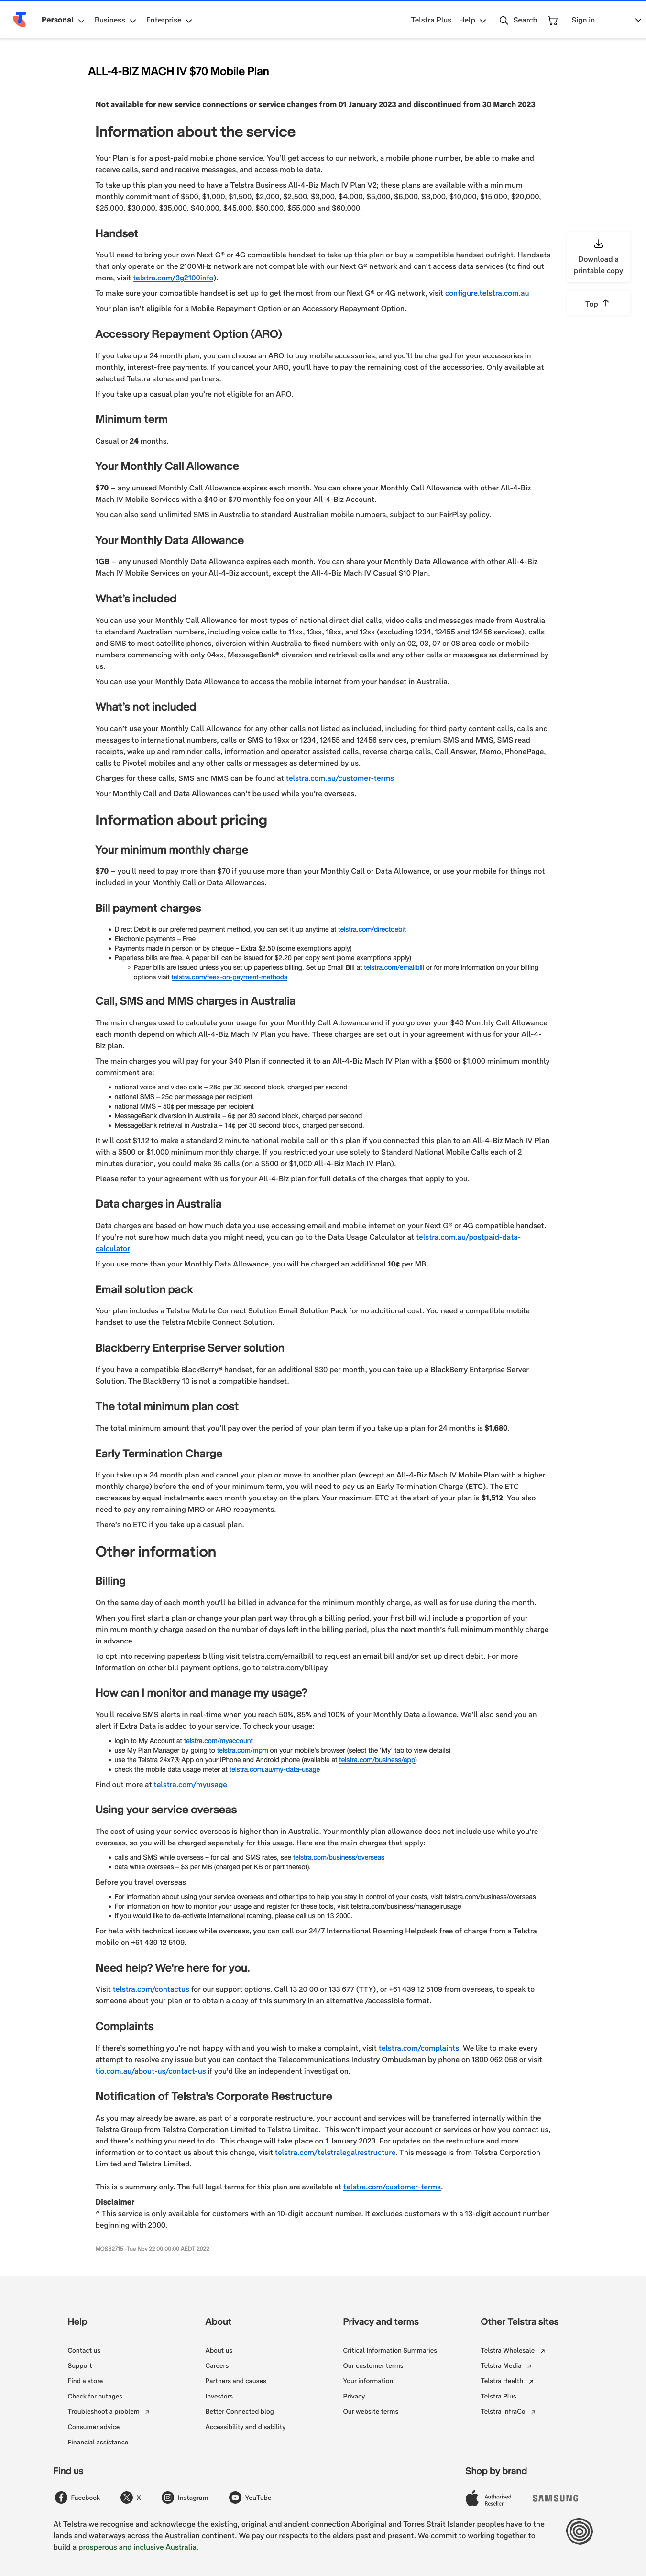

========= Scraped HTML ========

Page URL: https://www.telstra.com.au/help/critical-information-summaries/business/bundles/all-4-biz/telstra-business-all-4-biz-mach-iv-70-mobile-plan
Page Title: ALL-4-BIZ MACH IV $70 Mobile Plan
Token/chunk info:
- Text: Total GPT 3.5 Tokens: 5906
- Chunks: Total Chunks: 9

========= HTML 2 Text Page Content ========
Skip to main content

Telstra Personal Home Page

  * Personal

Personal Home

    * ##  Plans & devices

      * ###  Mobiles

        * Mobiles on a plan
        * SIM only plans
        * Bundle plans
        * Outright devices
        * Pre-Paid
        * Explore mobiles 

      * ###  Tablets

        * Tablets on a plan
        * Pre-Paid
        * Explore tablets 

      * ###  Laptops

      * ###  Home phones

      * ###  Roaming

      * ###  Deals

      * ###  Shop by Brand

        * Apple
        * Samsung
        * Google
        * Explore shop by brand 

      * ###  I want to I want to

        * Pay a bill
        * Upgr

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  7.45it/s]
/Users/michaeltremeer/opt/miniconda3/envs/telstra_opt/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.telstra.com.au'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


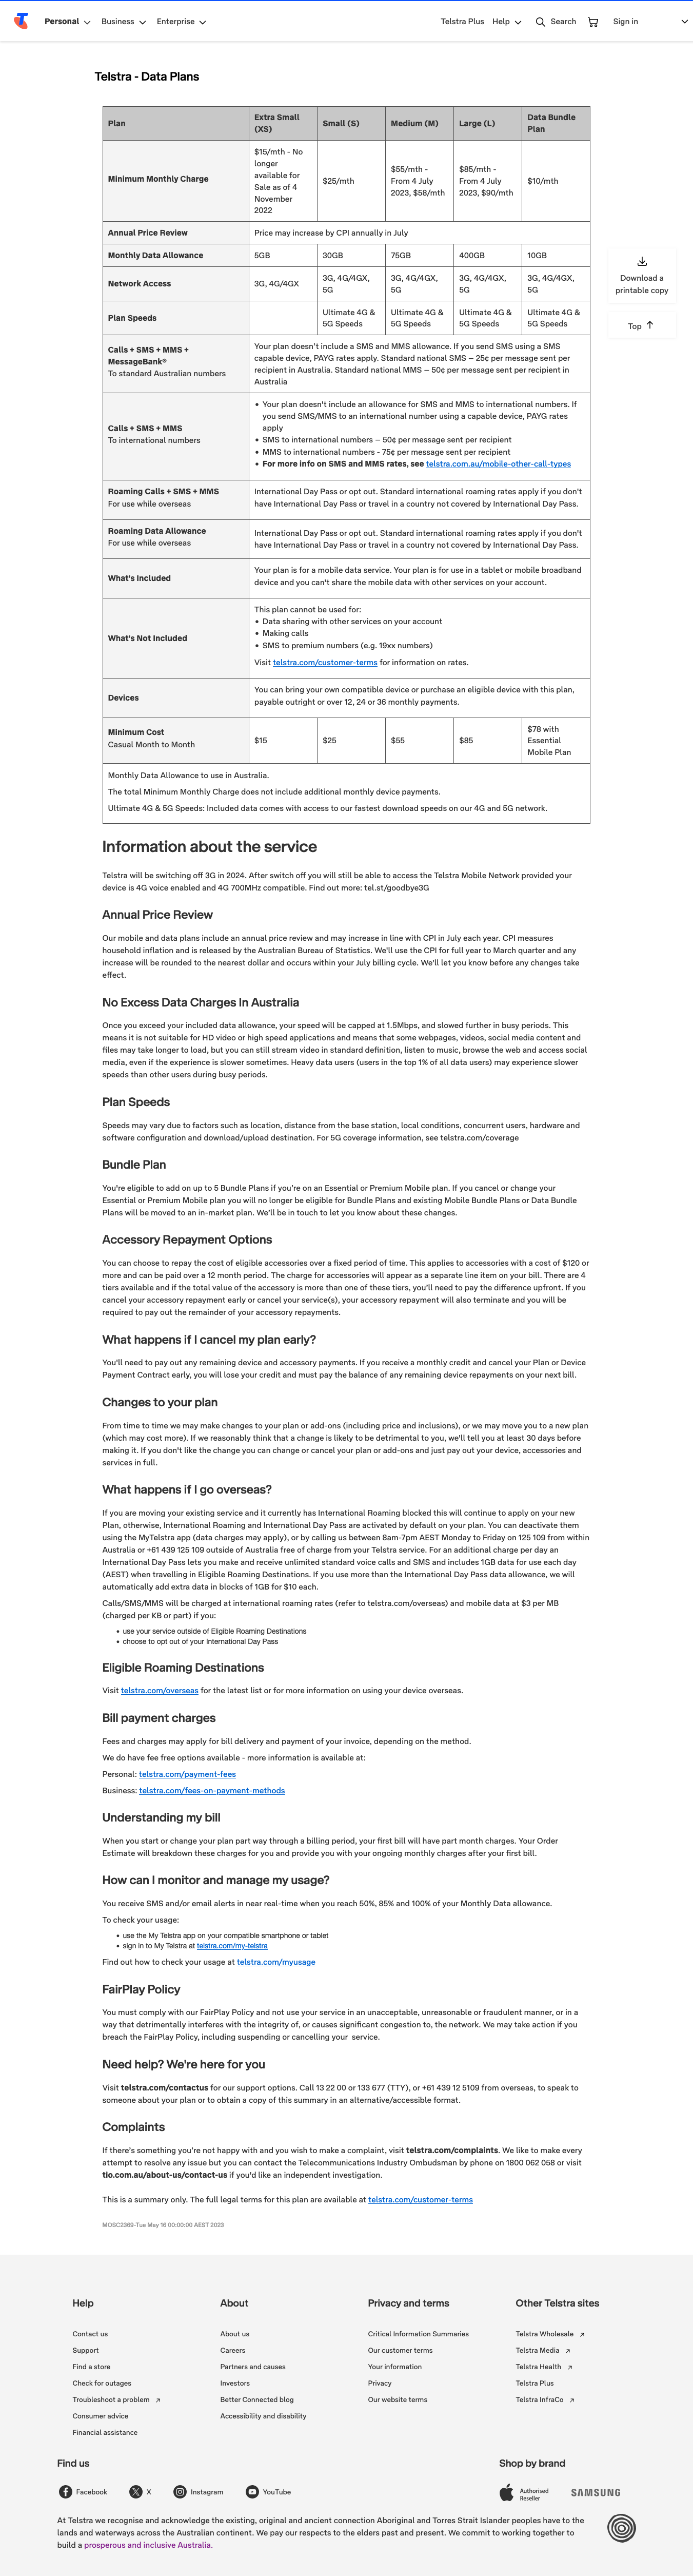

========= Scraped HTML ========

Page URL: https://www.telstra.com.au/help/critical-information-summaries/personal/mobile-broadband/mobile-broadband-plans/telstra-data-plans-may-2021
Page Title: Mobile Plans
Token/chunk info:
- Text: Total GPT 3.5 Tokens: 6676
- Chunks: Total Chunks: 10

========= HTML 2 Text Page Content ========
Skip to main content

Telstra Personal Home Page

  * Personal

Personal Home

    * ##  Plans & devices

      * ###  Mobiles

        * Mobiles on a plan
        * SIM only plans
        * Bundle plans
        * Outright devices
        * Pre-Paid
        * Explore mobiles 

      * ###  Tablets

        * Tablets on a plan
        * Pre-Paid
        * Explore tablets 

      * ###  Laptops

      * ###  Home phones

      * ###  Roaming

      * ###  Deals

      * ###  Shop by Brand

        * Apple
        * Samsung
        * Google
        * Explore shop by brand 

      * ###  I want to I want to

        * Pay a bill
        * Upgrade my plan
        

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  6.52it/s]
/Users/michaeltremeer/opt/miniconda3/envs/telstra_opt/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.telstra.com.au'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


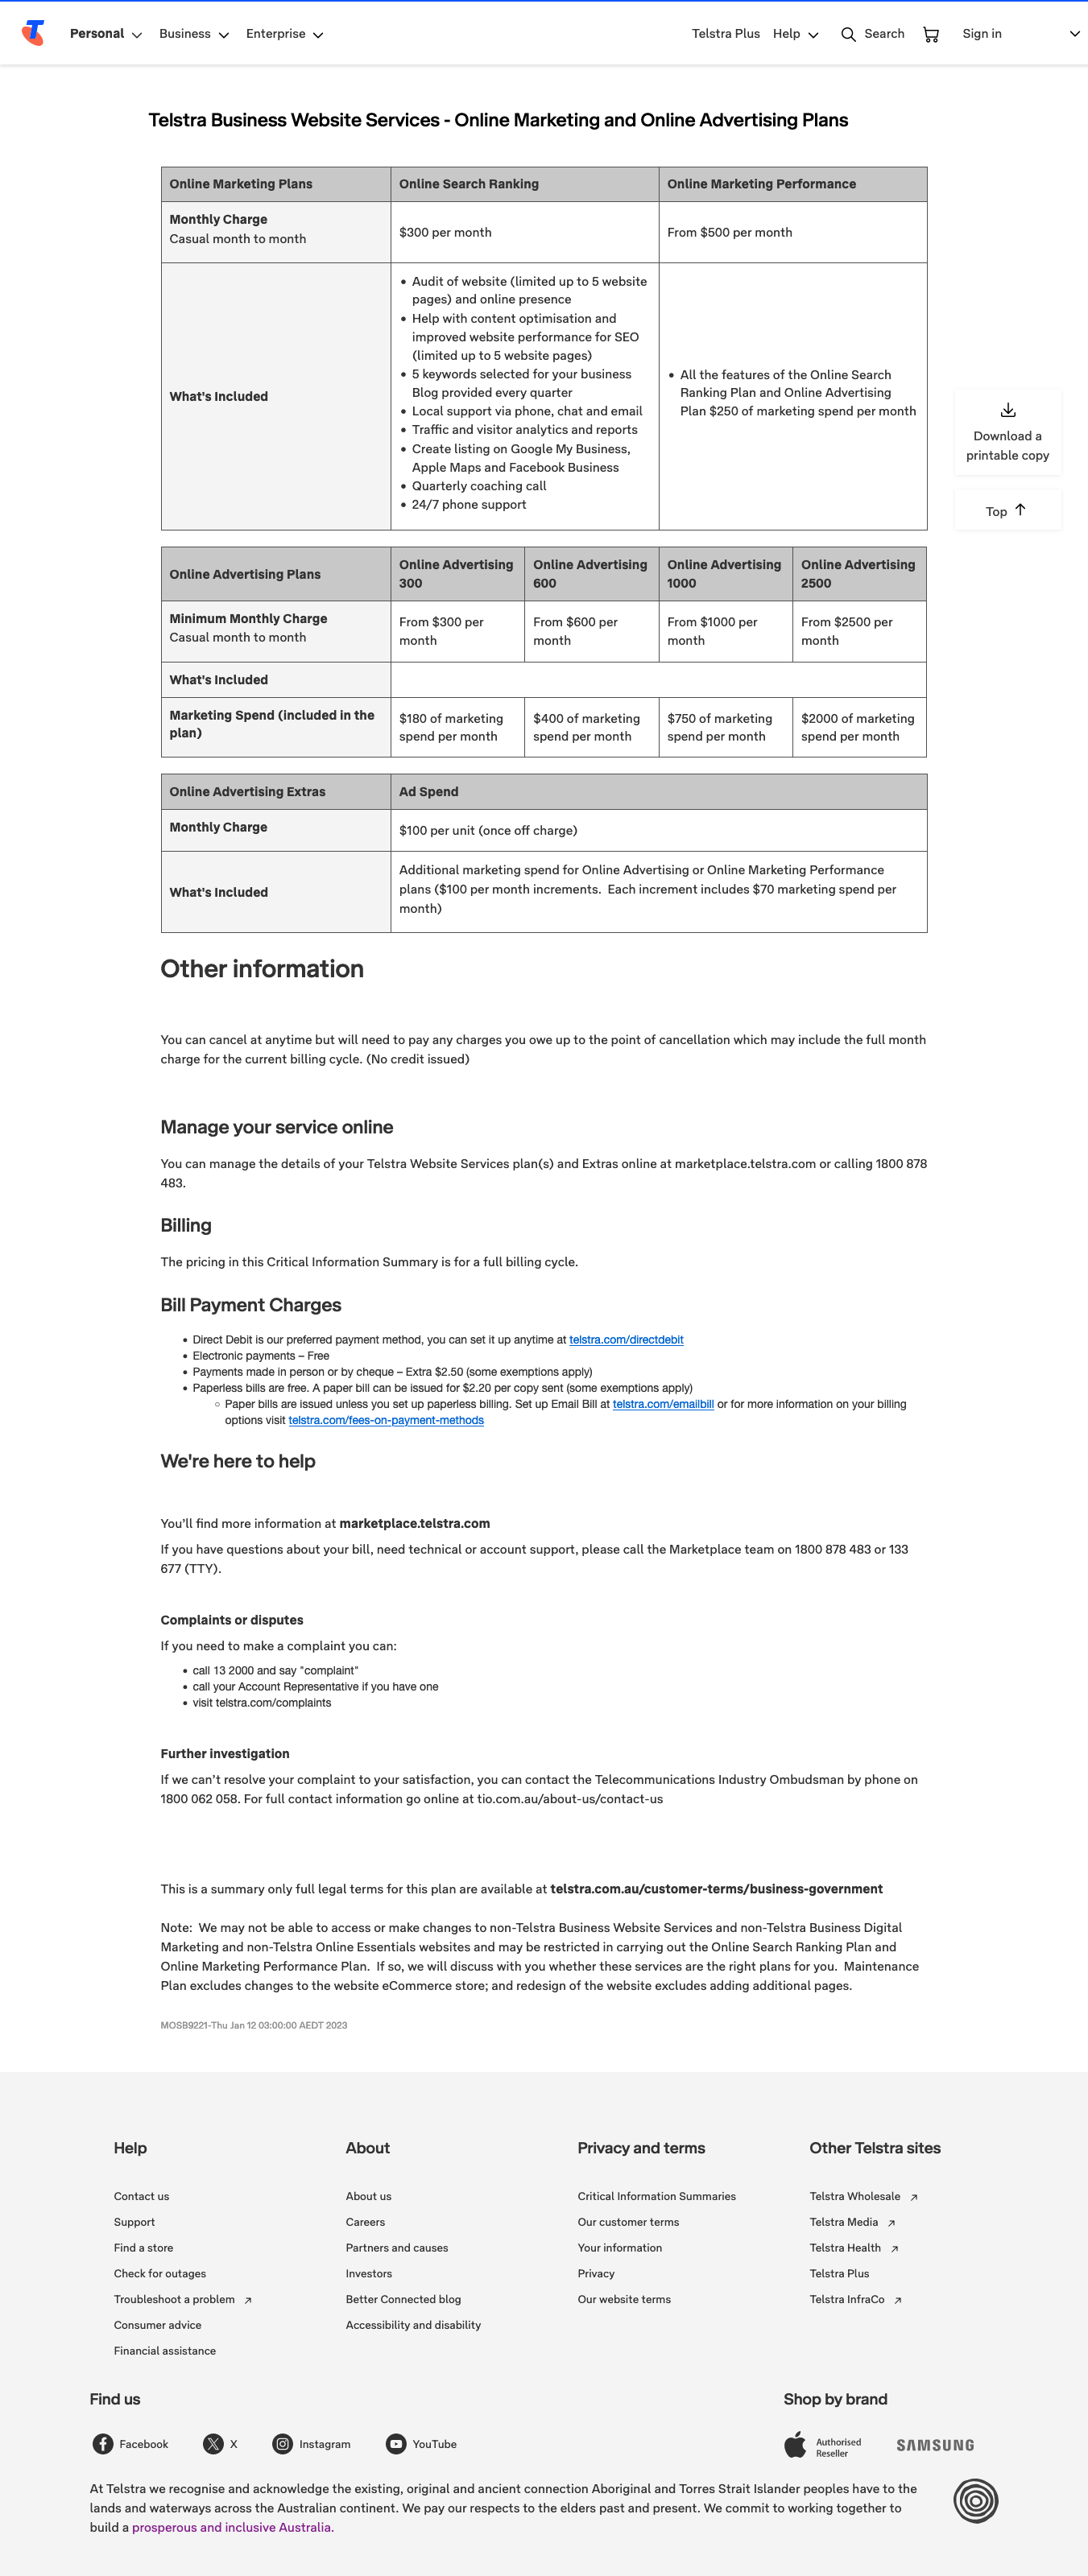

========= Scraped HTML ========

Page URL: https://www.telstra.com.au/help/critical-information-summaries/business/telstra-business-services/telstra-business-website-services/Telstra-Business-Website-Services-Online-Marketing-and-Online-Advertising-Plans
Page Title: Telstra - Telstra Business Services -Online Marketing and Online Advertising Plans
Token/chunk info:
- Text: Total GPT 3.5 Tokens: 6051
- Chunks: Total Chunks: 9

========= HTML 2 Text Page Content ========
Skip to main content

Telstra Personal Home Page

  * Personal

Personal Home

    * ##  Plans & devices

      * ###  Mobiles

        * Mobiles on a plan
        * SIM only plans
        * Bundle plans
        * Outright devices
        * Pre-Paid
        * Explore mobiles 

      * ###  Tablets

        * Tablets on a plan
        * Pre-Paid
        * Explore tablets 

      * ###  Laptops

      * ###  Home phones

      * ###  Roaming

      * ###  Deals

      * ###  Shop by Brand

        * Apple
        * Samsung

In [552]:
telstra_retriever = TelstraBingSearchRetriever()

for page_url in sample_df["loc"].tail(3):
    if page_url not in processed_page_data:
        processed_page_data[page_url] = dict()
        # Using Telstra's existing scraper
        telstra_default_content = telstra_retriever.load_and_process_webpage([page_url])
        processed_page_data[page_url]["telstra_default"] = telstra_default_content

        # Save full-page content using Selenium
        save_path = ANALYSIS_SAVE_DIR / (page_url.replace(TELSTRA_URL, "").replace("/", "_") + ".png")
        raw_html = save_page_screenshot_and_return_html(driver, page_url, save_path)
        processed_page_data[page_url]["raw_html"] = raw_html
        processed_page_data[page_url]["selenium_screenshot_path"] = save_path

    # Show full page content
    Image(filename=processed_page_data[page_url]["selenium_screenshot_path"], height=500) 

    print("========= Scraped HTML ========")
    html_doc = processed_page_data[page_url]["telstra_default"]["html_docs"][0]
    text_doc = processed_page_data[page_url]["telstra_default"]["text_docs"][0]
    chunked_docs = processed_page_data[page_url]["telstra_default"]["split_docs"]

    print("\nPage URL:", page_url)
    print("Page Title:", html_doc.metadata["title"])
    if "description" in html_doc.metadata:
        print("Description:", html_doc.metadata["description"])
    print("Token/chunk info:")
    print("- Text: Total GPT 3.5 Tokens:", num_tokens_from_text(text_doc.page_content, "gpt-3.5-turbo-0613"))
    print("- Chunks: Total Chunks:", len(chunked_docs))
    # print("HTML Content:\n")
    soup = BeautifulSoup(html_doc.page_content, 'html.parser')
    # print(soup.prettify())

    print("\n========= HTML 2 Text Page Content ========")
    
    print(text_doc.page_content)

    print(f"\n========= Split / Chunked Docs ({len(chunked_docs)} in total) ========")
    for i, chunked_doc in enumerate(chunked_docs, start=1):
        print(f"\n========= Chunk {i} ========")
        print("Number of chunk tokens:", chunked_doc.metadata["token_count"])

        print(chunked_doc.page_content)

    if page_url.startswith("https://www.telstra.com.au/help"):
        page_soup = BeautifulSoup(processed_page_data[page_url]["raw_html"], "html.parser")
        sectioned_help_page_docs = chunk_help_page_by_section(page_soup)
        print("Section documents:")
        for sectiond_doc in sectioned_help_page_docs:
            print(sectiond_doc)
        # print(sectioned_help_page_docs)

        single_md_help_page_docs = chunk_help_page_into_single_md(page_soup)
        print("Markdown documents:")
        for markdown_doc in single_md_help_page_docs:
            print(markdown_doc)
    

In [541]:
single_md_help_page_docs

[Document(page_content="\n\n\n Download a printable copy\n \n\n\n---\n\n\n\n\n\n\n\n\n\n| \n Recharge Amount\n  | \n $20\n  | \n $30\n  | \n $50\n  | \n $70\n  | \n $150\n  | \n $300\n  |  |\n| --- | --- | --- | --- | --- | --- | --- | --- |\n| \n\n Expiry\n \n | \n 14 days\n  | \n 28 days\n  | \n 28 days\n  | \n 28 days\n  | \n 12 months\n  | \n 12 months\n  |  |\n| \n\n Network Access\n \n\n 3G, 4G and 4GX\n \n | \n | \n | \n\n + 5G\n  | \n | \n | \n |  |\n| \n\n Data Allowance\n \n |  |  |  |  |  |  |  |\n| \n\n Data Allowance\n \n\n For use in Australia only\n \n | \n 10GB\n  | \n 20GB\n  | \n 40GB\n  | \n 300GB\n  | \n 60GB\n  | \n 200GB\n  |  |\n| \n\n Data Bank\n \n |  |  |  |  |  |  |  |\n| \n\n Continuous Data Rollover\n \n\n Recharge before expiry to save up to 200GB of unused data\n \n |  |  |  |  |  |  |  |\n| \n\n Data Rollover\n \n\n Recharge before expiry to rollover your unused data allowance to use in your next recharge\n \n | \n Recharge before expiry to rollover your